# Estimation

In [1]:
require(brms)
require(BEST)
require(tidyverse)
require(MASS)

Loading required package: brms

Loading required package: Rcpp

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Loading 'brms' package (version 2.10.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').

Loading required package: BEST

Loading required package: HDInterval

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




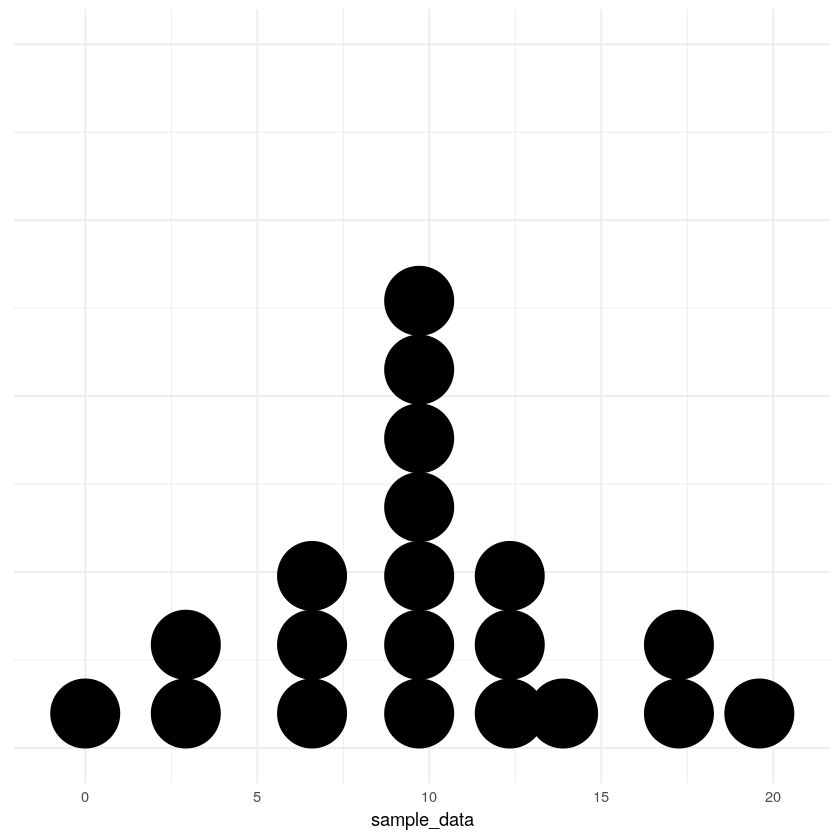

In [28]:
# 1

# lets generate some data specific characteristics
mu = 10
sigma = 5

# we'll generate N data point
N = 20

sample_data = as.numeric(mu + sigma * scale(rnorm(n = N, 0, 1)))

ggplot() + geom_dotplot(mapping = aes(x = sample_data),binwidth = 2) + 
scale_y_continuous(name = NULL, labels = NULL) + theme_minimal() 

In [53]:
# 2 

# lets like estimate the mean and sd

mean_opts = seq(9.8,10.2, by = .1) # some values for the mean to try out
sd_opts = seq(4.7, 5, length.out =  10000) # some values for the sd to try out

opts = cross_df(list(mean = mean_opts, 
              sd = sd_opts)) %>% set_names(c("m","s")) # make every possible combination of our two vectors

# write our liklihood function
norm.lik = function(D, m, s){
    
    # instead of working out the product of the likelihoods 
    # we'll just take the sum of the log values
    # because they're mathematically equivalent
    log.lik = sum(dnorm(sample_data, mean = m, sd = s, log = T))
    
    # then we just "un-log" it
    exp(log.lik)
    
}

log.likes = furrr::future_pmap_dbl(opts,  function(m,s) norm.lik(D = sample_data, m = m, s = s))
                                   
# find the row that contains the max likelihood
                                   
max.row = which.max(log.likes)                       

# get the mean and sd from this row
                                   
opts[max.row,] %>% 
glue::glue_data("our MLE for the mean is {round(m,3)} and for the sd is {round(s,3)}") %>%
IRdisplay::display_markdown()

our MLE for the mean is 10 and for the sd is 4.873

In [41]:
# 3

# Do mle the smart way!

mle_smart_way = MASS::fitdistr(sample_data, densfun = "normal") 
glue::glue("our MLE for the mean is {round(mle_smart_way$estimate[[1]],3)} 
and for the sd is {round(mle_smart_way$estimate[[2]],3)}") %>%
IRdisplay::display_markdown()

our MLE for the mean is 10 
and for the sd is 4.873

In [59]:
# 4

set.seed(3)
mu = 10
sigma = 5
N = 20
sample_data = mu + sigma * scale(rnorm(n = N, 0, 1))

# a toy MCMC algorithm

mean_estimate = mean(sample_data)
starting_mu = mean_estimate
sd_fixed = sqrt(sum((sample_data - mean_estimate)^2 * 1/N))
n_samples = 7000


parameter_sample = rep(0,n_samples)
parameter_sample[1] = starting_mu

for(i in 2 : n_samples){
  
  
  
  current_mu = parameter_sample[i-1]
  
  # get the product of the likelihood for the current mu value
  current_lik = sum(dnorm(sample_data, mean = current_mu, sd = sd_fixed, log = T))
  
  
  # take step 
  new_mu = current_mu  + rnorm(n = 1,0,1)
  
  # get product of likelihood for the new mu value
  
  new_lik = sum(dnorm(sample_data, mean = new_mu, sd = sd_fixed, log = T))
  
  
  prop = ifelse(new_lik > current_lik,.95,.2)
  
  if((runif(1) < prop)){
    parameter_sample[i] = new_mu
  } else {
    parameter_sample[i] = current_mu
  }
  
}

glue::glue("The mean of our means is {round(mean(parameter_sample),2)}") %>% IRdisplay::display_markdown()
glue::glue("The sd of our means is {round(sd(parameter_sample),2)}") %>% IRdisplay::display_markdown()

The mean of our means is 9.98

The sd of our means is 1.11

In [28]:
# 5

x = rnorm(n = 20, mean = 2, sd = 4)

delta = greta::rmal()


In [34]:
# estimate the mean 

mean_estimate = sum(sample_data * 1/N)

# estimate the sd of the data

sd_estimate = sqrt(sum((sample_data - mean_estimate)^2 * 1/N))

[1] 4.873397

In [36]:
mle_smart_way = MASS::fitdistr(sample_data, densfun = "normal") 

ERROR: Error in eval(expr, envir, enclos): trying to get slot "mean" from an object (class "fitdistr") that is not an S4 object 


In [14]:
mu = 10
sigma = 5
N = 20
sample_data = mu + sigma * scale(rnorm(n = N, 0, 1))

sample_data  = as.numeric(sample_data)
mean_opts = seq(9.8,10.2, by = .1)
sd_opts = seq(4.7, 5, length.out =  10000)  

cross_df(list(mean = mean_opts, 
              sd = sd_opts)) %>% set_names(c("m","s"))-> opts
furrr::future_pmap_dbl(opts,  function(m,s) sum(dnorm(sample_data, mean = m, sd = s, log = T))) -> mle
opts[which.max(mle),]

m,s
<dbl>,<dbl>
10,4.873387


In [15]:
MASS::fitdistr(sample_data, densfun = "normal")

      mean          sd    
  10.0000000    4.8733972 
 ( 1.0897247) ( 0.7705518)

In [51]:
set.seed(3)
mu = 10
sigma = 5
N = 20
sample_data = mu + sigma * scale(rnorm(n = N, 0, 1))

# a toy MCMC algorithm

mean_estimate = mean(sample_data)
starting_mu = mean_estimate
sd_fixed = sqrt(sum((sample_data - mean_estimate)^2 * 1/N))
n_samples = 7000


parameter_sample = rep(0,n_samples)
parameter_sample[1] = starting_mu

for(i in 2 : n_samples){
  
  
  
  current_mu = parameter_sample[i-1]
  
  # get the product of the likelihood for the current mu value
  current_lik = sum(dnorm(sample_data, mean = current_mu, sd = sd_fixed, log = T))
  
  
  # take step 
  new_mu = current_mu  + rnorm(n = 1,0,1)
  
  # get product of likelihood for the new mu value
  
  new_lik = sum(dnorm(sample_data, mean = new_mu, sd = sd_fixed, log = T))
  
  
  prop = ifelse(new_lik > current_lik,.95,.2)
  
  if((runif(1) < prop)){
    parameter_sample[i] = new_mu
  } else {
    parameter_sample[i] = current_mu
  }
  
}
mean(parameter_sample)
sd(parameter_sample)


[1] 9.978321

[1] 1.108863

In [158]:
current = sum(dnorm(sample_data, mean = new_mu, sd = sd_fixed, log = T))


In [190]:
current_lik = log(prod(dnorm(sample_data, mean = 10, sd = sd_fixed, log = F)))

In [221]:
prod(dnorm(sample_data, mean = 10, sd = sd_fixed, log = F))

[1] 8.291257e-27

In [249]:
exp(100)

[1] 2.688117e+43

In [ ]:
ggplot(mapping = aes(x = parameter_sample)) + geom_histogram(binwidth  = .1)


In [194]:
1 < exp(current_lik  / new_lik)


[1] TRUE

In [98]:
require(brms)

x =  as.numeric(2 + 4 * scale(rnorm(n = 10, 0, 1)))
xz = x / sd(x)
df = enframe(xz) %>% set_names(c("i","y"))

priors = prior(cauchy(0,1), class = "Intercept") + prior(cauchy(0,1), class = "sigma")
fit1 = brm(formula = y ~ 1, data = df, prior = priors, family = gaussian)


Compiling the C++ model

recompiling to avoid crashing R session

Start sampling




SAMPLING FOR MODEL '18e327419c687d89aecd2a9688580588' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.01351 seconds (Warm-up)
Chain 1:                0.016728 seconds (Sampling)
C

In [89]:
delta = posterior_samples(fit1, c("Intercept","sigma")) %>% set_names(c("delta","sigma")) %>% pull(delta)

In [101]:
require(logspline)
fitPost = logspline(delta)
BF_SD = dcauchy(0,0,1) / dlogspline(0,fitPost)
BF_SD

[1] 0.6462716

In [100]:
BayesFactor::ttestBF(x,rscale = 1)

Bayes factor analysis
--------------
[1] Alt., r=1 : 0.6623551 ±0%

Against denominator:
  Null, mu = 0 
---
Bayes factor type: BFoneSample, JZS


In [102]:
MASS::fitdistr(sample_data, densfun = "normal")

,Estimate,Est.Error,Q2.5,Q97.5
b_Intercept,0.4217975,0.3319315,-0.2556766,1.097511
sigma,1.0805280,0.2739644,0.6891034,1.735344
lp__,-17.2295682,1.0952343,-20.1907587,-16.177875


In [182]:
M = 29
SE = 30
N = 10

# characteristics of M priors
prior_M = 0
prior_sd = 40

data_model = bayesplay::scaled.shifted.t.lik(center = M, scale = SE, df = N-2)


h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0), # a point null with mean diff = 0
         theta.range = theta.range)
}

h1_model = function(theta.range){
    list(func = function(theta) dnorm(x = theta, mean = prior_M, sd = prior_sd), # uniform prior from 0 to 20
         theta.range = theta.range)
}


M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(0, Inf))


BF10 = M1$integral / M0$integral
glue::glue("B<sub>10</sub> = {round(BF10,3)}") %>% IRdisplay::display_markdown()


B<sub>10</sub> = 1.287

In [53]:
require(bayesplay)
data_model = bayesplay::scaled.shifted.t.lik(center = 1.8, scale = 0.36, df = 18)
#data_model = bayesplay::norm.lik(center = 1.8, scale = 0.36)


h0_model = function(theta.range){
    list(func = function(theta) ifelse(theta == 0, 1, 0), # a point null with mean diff = 0
         theta.range = theta.range)
}

h1_model = function(theta.range){
    list(func = function(theta) dnorm(x = theta, mean = 0, sd = 7), # uniform prior from 0 to 20
         theta.range = theta.range)
}


M0 = data_model * h0_model(theta.range = c(0,0))

M1 = data_model * h1_model(theta.range = c(0, Inf))


BF10 = M1$integral / M0$integral
glue::glue("B<sub>01</sub> = {round(BF10,5)}") %>% IRdisplay::display_markdown()


B<sub>01</sub> = 394.5874

In [196]:
# characteristics of the data

M = 29
SE = 30
N = 10

# characteristics of M priors
prior_M = 0
prior_sd = 40

GenSynthSample = function(mean, sd, se, n){
  inputs = as.list(sys.call())
  if(sum(names(inputs) %in% c("se","sd")) == 2){
    stop("input se OR sd")
  }
  
  if("se" %in% names(inputs)){
    sd = se * sqrt(n)
  }
  
  x = mean + sd * scale(rnorm(n, 0, 1))
  return(x)
}


x =  GenSynthSample(mean = M, se = SE, n = N)

mu = normal(0,prior_sd, truncation = c(0,Inf))
#sigma = cauchy(0,2, truncation = c(0,Inf))
sigma = uniform(min = 0, max = 2 * (SE * sqrt(N)))


distribution(x) = normal(mu,sigma)

m = model(mu,sigma)


draws = mcmc(m, n_samples = 10000, verbose = FALSE)

posteriorMu = draws[[1]][,1]


fitPost = logspline(posteriorMu)
BF_SD =  dlogspline(0,fitPost) /(dnorm(0,0,prior_sd) * 2)
BF_SD





[1] 0.1843338

In [200]:
dlogspline(0,fitPost) / (.25 * dnorm(0,0,prior_sd))

[1] 1.47467

In [201]:
summary(draws)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean    SD Naive SE Time-series SE
mu     27.74 18.38  0.09191        0.09764
sigma 104.37 25.21  0.12605        0.15204

2. Quantiles for each variable:

       2.5%   25%    50%    75%  97.5%
mu     1.54 13.17  25.11  39.18  69.61
sigma 66.35 85.90 100.21 118.81 164.81


In [153]:
norm.lik <- function(center, scale){
  lik.func <- function(theta){dnorm(x = center, mean = theta, sd = scale)}
  params = list(center = center, scale = scale, df = df)
  desc = paste0("Parameters\nCenter: ",params$center,"\nScale: ",params$scale)
  new(Class = 'likelihood',
      data = list(lik.type = "normal", parameters = params),
      func = lik.func,
      desc = desc,
      dist.type = "continuous")
}

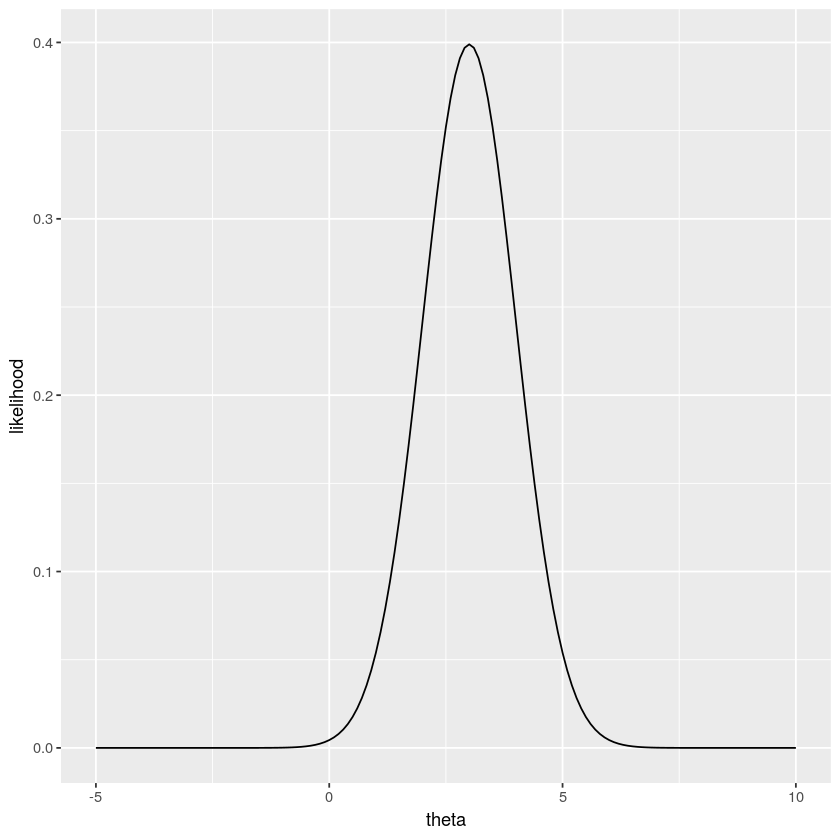

In [160]:
data_model1 = norm.lik(center = 3, scale = 1)
plot(data_model1,seq(-5,10,.1))

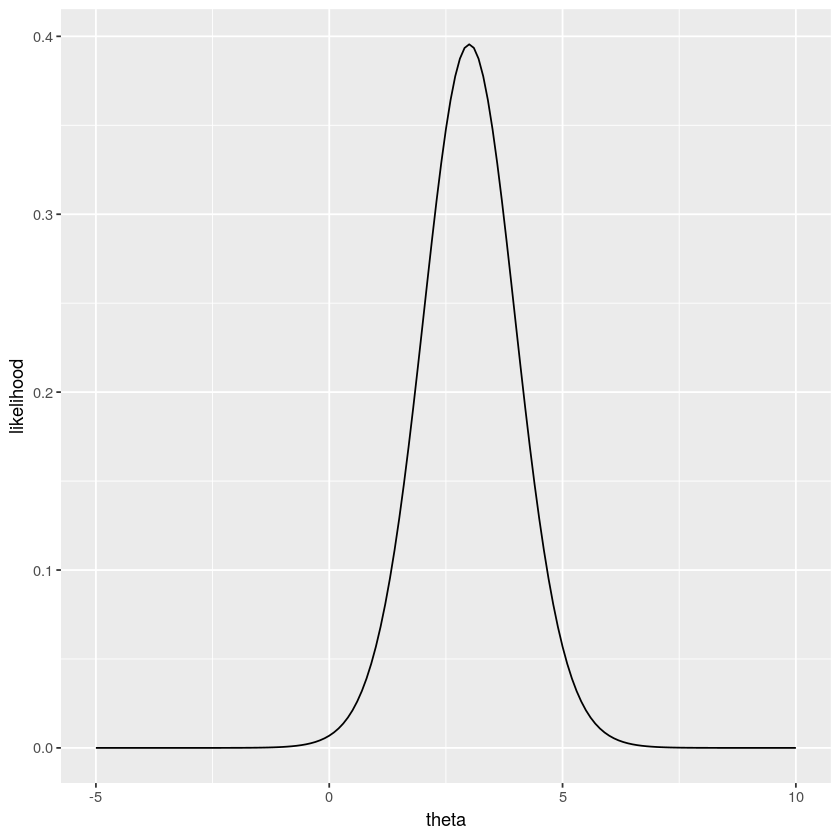

In [161]:
data_model2 = bayesplay::scaled.shifted.t.lik(center = 3, scale = 1, df = 29)
plot(data_model2,seq(-5,10,.1))

In [12]:
# Bayesian Estimate in the style of Bayesian Estimation Supersedes T-Tests (BEST)

x =  GenSynthSample(mean = 20, sd = 5, n = 100)


# Define model 

mu = greta::normal(mean = mean(x), sd = sd(x) * 1000)
sigma = greta::uniform(min = sd(x)/1000, max = sd(x) * 1000)
nu = greta::exponential(1/29) + 1

greta::distribution(x) = greta::student(mu = mu, sigma = sigma, df = nu)

m = greta::model(mu, sigma, nu)

posterior_samples = greta::mcmc(m, n_samples = 10000)



running 4 chains simultaneously on up to 6 cores



    warmup                                           0/1000 | eta:  ?s          

    warmup ==                                       50/1000 | eta: 26s          

    warmup ====                                    100/1000 | eta: 18s          

    warmup =====                                   150/1000 | eta: 15s          

    warmup =======                                 200/1000 | eta: 13s          

    warmup =========                               250/1000 | eta: 12s          

    warmup ===========                             300/1000 | eta: 11s          

    warmup =============                           350/1000 | eta: 10s          

    warmup ==============                          400/1000 | eta:  9s          

    warmup ================                        450/1000 | eta:  8s          

    warmup ==================                      500/1000 | eta:  7s          

    warmup ====================              


  sampling ==============                        3950/10000 | eta:  1m          

  sampling ==============                        4000/10000 | eta:  1m          

  sampling ===============                       4050/10000 | eta:  1m          

  sampling ===============                       4100/10000 | eta:  1m          

  sampling ===============                       4150/10000 | eta:  1m          

  sampling ===============                       4200/10000 | eta:  1m          

  sampling ===============                       4250/10000 | eta:  1m          

  sampling ===============                       4300/10000 | eta:  1m          

  sampling ================                      4350/10000 | eta:  1m          

  sampling ================                      4400/10000 | eta:  1m          

  sampling ================                      4450/10000 | eta:  1m          

  sampling ================                      4500/10000 | eta:  1m          

  sampling ====


  sampling ================================      8950/10000 | eta: 11s          

  sampling ================================      9000/10000 | eta: 10s          

  sampling =================================     9050/10000 | eta: 10s          

  sampling =================================     9100/10000 | eta:  9s          

  sampling =================================     9150/10000 | eta:  9s          

  sampling =================================     9200/10000 | eta:  8s          

  sampling =================================     9250/10000 | eta:  8s          

  sampling =================================     9300/10000 | eta:  7s          

  sampling ==================================    9350/10000 | eta:  7s          

  sampling ==================================    9400/10000 | eta:  6s          

  sampling ==================================    9450/10000 | eta:  6s          

  sampling ==================================    9500/10000 | eta:  5s          

  sampling ====

In [13]:
summary(posterior_samples)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD Naive SE Time-series SE
sigma  4.879  0.3967 0.001983       0.003645
nu    39.033 29.9223 0.149611       0.163890
mu    20.040  0.5099 0.002549       0.005567

2. Quantiles for each variable:

        2.5%   25%    50%    75%   97.5%
sigma  4.142  4.61  4.864  5.131   5.701
nu     6.870 17.89 30.561 51.258 117.794
mu    19.039 19.70 20.041 20.382  21.050


In [15]:
b = BEST::BESTmcmc(x)
summary(b)

Waiting for parallel processing to complete...
done.



,mean,median,mode,HDI%,HDIlo,HDIup,compVal,%>compVal,ROPElow,ROPEhigh,%InROPE
mu,20.034088,20.033745,20.020033,95,19.0508915,21.053807,0,100,NA,NA,NA
sigma,4.880115,4.862780,4.826927,95,4.1128495,5.657865,NA,NA,NA,NA,NA
nu,39.070688,30.673816,15.968614,95,3.6281833,98.500875,NA,NA,NA,NA,NA
log10nu,1.479177,1.486768,1.467578,95,0.8640078,2.088541,NA,NA,NA,NA,NA
effSz,4.132215,4.118373,4.096924,95,3.4616168,4.837233,0,100,NA,NA,NA


In [226]:
names(m$target_greta_arrays)

mu = posterior_samples[[1]][,1]
sigma = posterior_samples[[1]][,2]
nu = posterior_samples[[1]][,3]

[1] "mu"    "sigma" "nu"

In [231]:
summary(posterior_samples)


Iterations = 1:10000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD  Naive SE Time-series SE
nu     0.8732 0.1256 0.0006282      0.0008094
mu    19.5789 0.4946 0.0024731      0.0033988
sigma  2.9336 0.4126 0.0020631      0.0031199

2. Quantiles for each variable:

         2.5%     25%     50%     75%  97.5%
nu     0.6519  0.7855  0.8646  0.9513  1.143
mu    18.6080 19.2471 19.5792 19.9104 20.546
sigma  2.1918  2.6457  2.9103  3.1956  3.812


In [8]:
x =  GenSynthSample(mean = 20, sd = 5, n = 100)


data = tibble(y = x)

mean_y = mean(data$y)
sd_y = sd(data$y)

stanvars <- 
  stanvar(mean_y, name = "mean_y") + 
  stanvar(sd_y,   name = "sd_y") + 
  stanvar(1/29,   name = "one_over_twentynine")


priors <- 
prior(normal(mean_y, sd_y * 1000), class = Intercept) +
prior(cauchy(0, sd_y), class = sigma) +
prior(exponential(one_over_twentynine), class = nu)







In [9]:
fit2 <-
  brm(data = data,
      family = student,
      y ~ 1,
      prior = priors,
      chains = 4, cores = 4,
      stanvars = stanvars,
      seed = 12)


Compiling the C++ model

Start sampling



In [5]:
GenSynthSample = function(mean, sd, se, n){
  inputs = as.list(sys.call())
  if(sum(names(inputs) %in% c("se","sd")) == 2){
    stop("input se OR sd")
  }
  
  if("se" %in% names(inputs)){
    sd = se * sqrt(n)
  }
  
  x = mean + sd * scale(rnorm(n, 0, 1))
  return(x)
}

In [10]:
b = BEST::(x)
summary(b)

Waiting for parallel processing to complete...
done.



,mean,median,mode,HDI%,HDIlo,HDIup,compVal,%>compVal,ROPElow,ROPEhigh,%InROPE
mu,20.081496,20.084367,20.109459,95,19.082665,21.075291,0,100,NA,NA,NA
sigma,4.827858,4.818996,4.830912,95,4.032929,5.650873,NA,NA,NA,NA,NA
nu,35.706849,27.150934,12.819064,95,2.917887,93.893325,NA,NA,NA,NA,NA
log10nu,1.425915,1.433785,1.475224,95,0.766263,2.048769,NA,NA,NA,NA,NA
effSz,4.190424,4.166844,4.110044,95,3.459129,4.954716,0,100,NA,NA,NA


In [11]:
summary(fit2)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: y ~ 1 
   Data: data (Number of observations: 100) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept    20.09      0.50    19.09    21.07 1.00     3419     3105

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma     4.78      0.40     4.03     5.58 1.00     2804     2713
nu       34.58     28.85     5.77   115.84 1.00     2526     2877

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample 
is a crude measure of effective sample size, and Rhat is the potential 
scale reduction factor on split chains (at convergence, Rhat = 1).